In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.dates as mdates
import numpy as np

import intake

from functions_collector import xr_pearsonr          # computes r and p given two xarrays
from functions_collector import gaussian_filter_nan  # very useful for filtering in time

import sys
sys.path.append("/work/mh1498/m301248/TCO_data/COARE-algorithm/Python/COARE3.5/") 

In [3]:
%load_ext autoreload
%autoreload 2

Diregarding intra-seasonal advection, the mean moisture profile is simply set by th balance between boundary layer top and surface fluxes.
$$ q_\mathrm{bl} = \frac{V_\mathrm{sfc} q_\mathrm{sfc} + E q_{h^+}}{V_\mathrm{sfc} + E}$$


then at the surface

$$ W_\mathrm{sfc} \approx \frac{q_\mathrm{bl}}{q_\mathrm{sfc}}  = \frac{V_\mathrm{sfc} + E \frac{q_{h^+}}{q_\mathrm{sfc}} }{V_\mathrm{sfc} + E} = \frac{V_\mathrm{sfc} + \chi \cdot E}{V_\mathrm{sfc} + E} $$

from this, I can rearrange the terms to estimate values for the vertical mass transport needed to attain such surface relative humidity $W_\mathrm{sfc}$

$$ E = \frac{\left( 1 - W_\mathrm{sfc} \right) \cdot V_\mathrm{sfc}}{W + \chi} $$

From the radiosoundings, $W_\mathrm{sfc} = 0.75$ .

Far reaching idea: use computed $E$ in bulk equation from $\theta$


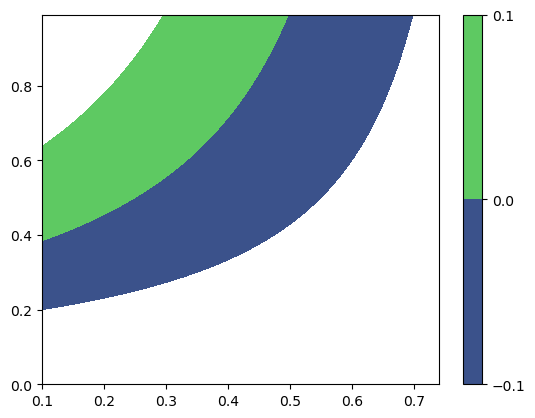

In [13]:
import numpy as np

W = 0.75

chi = np.arange(0.1,W-0.005,0.01)
alpha = np.arange(0, 1, 0.01)
 

CHI, ALPHA = np.meshgrid(chi, alpha)

f = W - (1+CHI*ALPHA)/(1+ALPHA)

plt.contourf(CHI, ALPHA, f, levels=[-0.1, 0, 0.1])
plt.colorbar()


# plt.plot(chi, (W-1)/(chi-W))


plt.show()

#### load profiles

In [4]:
level2_path = "/work/mh1498/m301248/TCO_data/eurec4a_profiles_level2/EUREC4A_BCO_Vaisala-RS_L2_v3.0.0.nc"
ds_eureca = xr.open_dataset(level2_path)
ds_eureca_bco = ds_eureca.where(((ds_eureca["platform"] == 1)&(ds_eureca["ascent_flag"]==1)&(ds_eureca.alt>40.)), drop=True)


ds_orcestra = xr.open_dataset("ipfs://bafybeid7cnw62zmzfgxcvc6q6fa267a7ivk2wcchbmkoyk4kdi5z2yj2w4", engine="zarr")
ds_orcestra
ds_orcestra_bco = ds_orcestra.where(((ds_orcestra["platform"] == "BCO")&(ds_orcestra["ascent_flag"]==0)&(ds_orcestra.height>40.)), drop=True)


In [5]:
## campaign-mean profiles
rh_eu = ds_eureca_bco.rh.mean(dim="sounding")
wind_eu = ds_eureca_bco.wspd.mean(dim="sounding")
temp_eu = ds_eureca_bco.ta.mean(dim="sounding")
q_eu = ds_eureca_bco.q.mean(dim="sounding")

rh_or = ds_orcestra_bco.rh.mean(dim="launch_time")
wind_or = ds_orcestra_bco.wspd.mean(dim="launch_time")
temp_or = ds_orcestra_bco.ta.mean(dim="launch_time")
q_or = ds_orcestra_bco.q.mean(dim="launch_time")


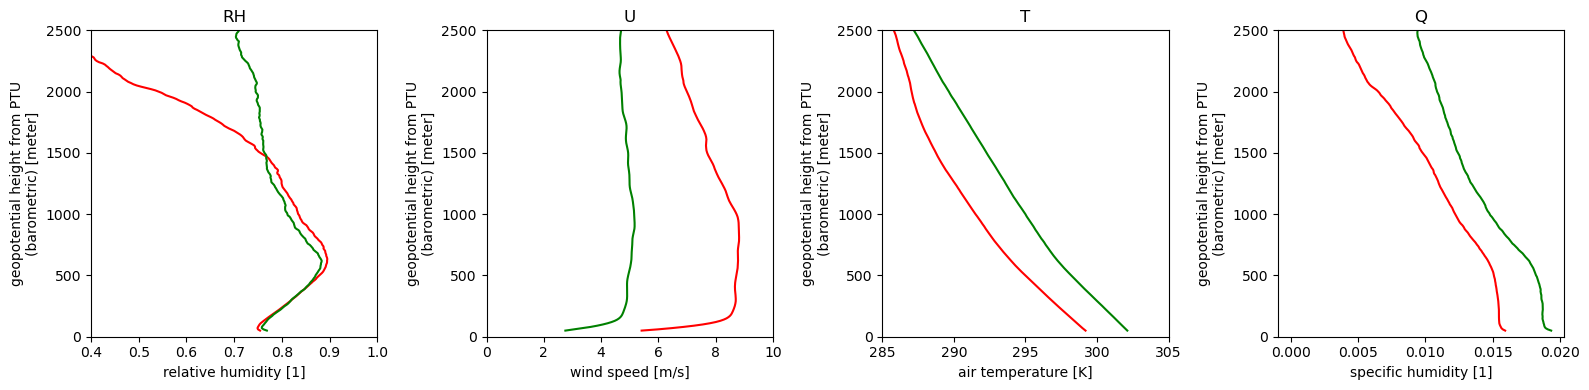

In [35]:


fig, ax = plt.subplots(1,4, figsize=(16,4))

rh_eu.plot.line(ax=ax[0], y="alt", color="red")
rh_or.plot.line(ax=ax[0], y="height", color="green")
ax[0].set_title("RH")
ax[0].set_xlim(0.4, 1)

wind_eu.plot.line(ax=ax[1], y="alt", color="red")
wind_or.plot.line(ax=ax[1], y="height", color="green")
ax[1].set_title("U")
ax[1].set_xlim(0, 10)


temp_eu.plot.line(ax=ax[2], y="alt", color="red")
temp_or.plot.line(ax=ax[2], y="height", color="green")
ax[2].set_title("T")
ax[2].set_xlim(285, 305)


q_eu.plot.line(ax=ax[3], y="alt", color="red")
q_or.plot.line(ax=ax[3], y="height", color="green")
ax[3].set_title("Q")
# ax[2].set_xlim(285, 305)



for x in ax:
    x.set_ylim(0,2.5e3)


plt.tight_layout()


In [6]:
## load campaign-mean SST data
ingr_eu = xr.open_dataset("/work/mh1498/m301248/TCO_data/fluxes_data/EUREC4A_IngrFlux.nc")
sst_eu = ingr_eu.sst.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

ingr_or = xr.open_dataset("/work/mh1498/m301248/TCO_data/fluxes_data/ORCESTRA_IngrFlux.nc")
sst_or = ingr_or.sst.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

In [7]:
## compute mean q_sfc
from meteo import qsea

sst_local = ingr_eu.sst.sel(cell=[17,24,31,18,25,32, 19,26,33])
q_sfc_eu = qsea(sst_local-273.15, 1013.)
q_sfc_eu = np.mean(q_sfc_eu)

sst_local = ingr_or.sst.sel(cell=[17,24,31,18,25,32, 19,26,33])
q_sfc_or = qsea(sst_local-273.15, 1013.)
q_sfc_or = np.mean(q_sfc_or)

#### do U and q_sfc or fluxes compensate ?

In [8]:
fluxes_eu = xr.open_dataset("/work/mh1498/m301248/TCO_data/fluxes_data/sfcFluxes_EUREC4A.nc")
lhf_eu = fluxes_eu.lhf.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

fuxes_or = xr.open_dataset("/work/mh1498/m301248/TCO_data/fluxes_data/sfcFluxes_ORCESTRA.nc")
lhf_or = fuxes_or.lhf.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

In [9]:
print(f"Uq EU = {(wind_eu.isel(alt=0)*q_sfc_eu):.2f} ; Uq OR = {(wind_or.isel(height=0)*q_sfc_or):.2f}")
print(f"LHF ERA5 EU = {lhf_eu.values:.2f}  ;  LHF ERA5 EU = {lhf_or.values:.2f}")
print("check how the drag coefficients change!")

Uq EU = 119.22 ; Uq OR = 71.95
LHF ERA5 EU = 171.35  ;  LHF ERA5 EU = 134.73
check how the drag coefficients change!


In [10]:
import coare35vn

## ATTENTION: here output only [hsb,hlb, rhoa, Ch,Ce]

u = wind_eu.isel(alt=0)
t = temp_eu.isel(alt=0)
rh = rh_eu.isel(alt=0)
ts = sst_eu
P = 1013.
Rs = ingr_eu.sw_global.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])
Rl = ingr_eu.lw_diff.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

output_eu = coare35vn.coare35vn(u=u.values,
                             t=t.values-273.15,
                             rh=100*rh.values,
                             ts=ts.values-273.15,
                             P=P,
                             Rs=Rs.values,
                             Rl=Rl.values, 
                             zu=50, zt=50, zq=50, lat=13, zi=600, rain=None, cp=None, sigH=None, jcool=1)




u = wind_or.isel(height=0)
t = temp_or.isel(height=0)
rh = rh_or.isel(height=0)
ts = sst_or
P = 1013.
Rs = ingr_or.sw_global.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])
Rl = ingr_or.lw_diff.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

output_or = coare35vn.coare35vn(u=u.values,
                             t=t.values-273.15,
                             rh=100*rh.values,
                             ts=ts.values-273.15,
                             P=P,
                             Rs=Rs.values,
                             Rl=Rl.values, 
                             zu=50, zt=50, zq=50, lat=13, zi=600, rain=None, cp=None, sigH=None, jcool=1)


/work/mh1498/m301248/TCO_data/COARE-algorithm/Python/COARE3.5/meteo.py:156: RuntimeWarning: invalid value encountered in power
  psi = -((1 + 0.6667*zet)**1.5 + 0.6667*(zet - 14.28)*exp(-dzet) + 8.525)


In [11]:
rho_eu, Ce_eu = output_eu[0,2], output_eu[0,4]
rho_or, Ce_or = output_or[0,2], output_or[0,4]

lhf_eu_rec, lhf_or_rec = output_eu[0,1], output_or[0,1]

In [13]:
print(f"Uq EU = {(wind_eu.isel(alt=0)*q_sfc_eu):.2f} ; Uq OR = {(wind_or.isel(height=0)*q_sfc_or):.2f}")
print(f"rho Ce Uq EU = {(rho_eu*Ce_eu*wind_eu.isel(alt=0)*q_sfc_eu):.2f} ; rho Ce Uq OR = {(rho_or*Ce_or*wind_or.isel(height=0)*q_sfc_or):.2f}")

print(f"Ce EU = {(Ce_eu):.5f} ; Ce OR = {(Ce_or):.5f}")


print(f"LHF ERA5 EU = {lhf_eu.values:.2f}  ;  LHF ERA5 EU = {lhf_or.values:.2f}")
print(f"LHF EU from prof = {lhf_eu_rec:.2f}  ;  LHF ERA5 EU = {lhf_or_rec:.2f}")


Uq EU = 119.22 ; Uq OR = 71.95
rho Ce Uq EU = 0.16 ; rho Ce Uq OR = 0.11
Ce EU = 0.00113 ; Ce OR = 0.00134
LHF ERA5 EU = 171.35  ;  LHF ERA5 EU = 134.73
LHF EU from prof = 102.70  ;  LHF ERA5 EU = 69.45


In [22]:
import pandas as pd
from IPython.display import display, HTML

data = [
    [r"Uq (m/s g/kg)", f"{(wind_eu.isel(alt=0) * q_sfc_eu):.2f}", f"{(wind_or.isel(height=0) * q_sfc_or):.2f}"],
    ["ρCeUq (kg / m²s)", f"{(rho_eu * Ce_eu * wind_eu.isel(alt=0) * q_sfc_eu):.2f}", f"{(rho_or * Ce_or * wind_or.isel(height=0) * q_sfc_or):.2f}"],
    ["Ce", f"{Ce_eu:.5f}", f"{Ce_or:.5f}"],
    ["LHF ERA5 (W/m²)", f"{lhf_eu:.2f}", f"{lhf_or:.2f}"],
    ["LHF from Prof (50m) (W/m²)", f"{lhf_eu_rec:.2f}", f"{lhf_or_rec:.2f}"],
]

# Create DataFrame
df = pd.DataFrame(data, columns=["Quantity", "EU", "OR"])

display(HTML(df.to_html(index=False, table_id="summary-table")))

Quantity,EU,OR
Uq (m/s g/kg),119.22,71.95
ρCeUq (kg / m²s),0.16,0.11
Ce,0.00113,0.00134
LHF ERA5 (W/m²),171.35,134.73
LHF from Prof (50m) (W/m²),102.70,69.45


In [36]:
q_out_eu = q_eu.isel(alt=slice(100, 200)).values
q_out_or = q_or.isel(height=slice(100, 200)).values

def E(q_out, q_sfc, Vs, W=0.75):
    E = ((W-1)*Vs)/((q_out/q_sfc)-W)
    return E

Vs_eu = (rho_eu * Ce_eu * wind_eu.isel(alt=0)).values
Vs_or = (rho_or * Ce_or * wind_or.isel(height=0)).values

## compute a series of E values
E_values_eu = E(q_out_eu*1e3, q_sfc_eu, Vs_eu)
E_values_or = E(q_out_or*1e3, q_sfc_or, Vs_or)

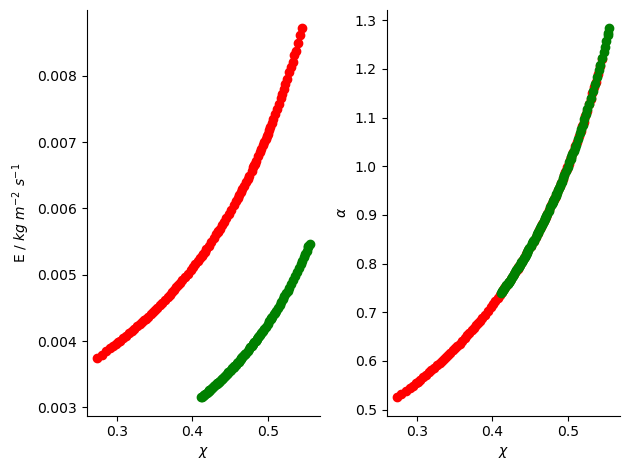

In [37]:
fig, ax = plt.subplots(1,2)

ax[0].scatter(q_out_eu*1e3/q_sfc_eu, E_values_eu, color="red", label="EUREC4A")
ax[0].scatter(q_out_or*1e3/q_sfc_or, E_values_or, color="green", label="ORCESTRA")

# ax[0].set_xlabel(r"$q_\mathrm{out}$ / $g~kg^{-1}$")
ax[0].set_xlabel(r"$\chi$")
ax[0].set_ylabel(r"E / $kg~m^{-2}~s^{-1}$")


ax[1].scatter(q_out_eu*1e3/q_sfc_eu, E_values_eu/Vs_eu, color="red", label="EUREC4A")
ax[1].scatter(q_out_or*1e3/q_sfc_or, E_values_or/Vs_or, color="green", label="ORCESTRA")

ax[1].set_xlabel(r"$\chi$")
ax[1].set_ylabel(r"$\alpha$")


for x in ax:
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)



plt.tight_layout()
plt.show()